# Simulación Magnetrómetro de efecto Kerr magnetro-óptico

El efecto Keer magneto-óptico (MOKE) consiste en la insidencia de un haz electromagnético polarizado linealmente sobre una muestra,lo cual genera la oscilación de electrones a lo largo de la polarización de la onda incidente, generando una onda linealmente polarizada en el mismo plano que el haz inicial. En el caso de una muestra ferromagnética, dónde existe un magnetización sobre el material, se agrega un componente extra a la direcceción de polarización de la onda reflejada. Al agregar un campo magnético externo, podemos medir la variación de la dirección de la magnetización con respecto a la intensidad del campo eléctrico externo midiendo la variación del plano de polarización de la onda reflejada.

Se simuilará la señal de efecto Kerr en la diferentes direcciones del campo magnético externo sobre la muestra, mediante la medición del angulo de la magnetización con respecto al eje [110] minimizando la energía libre anisotrópica para cada valor de la intensidad del campo mangético externo y para cada ángulo de este con respecto al eje [110].

In [1]:
""" Cargamos las funciones de energía libre 
y de minimización que no da los angulos del campo magnético """

from libreria import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

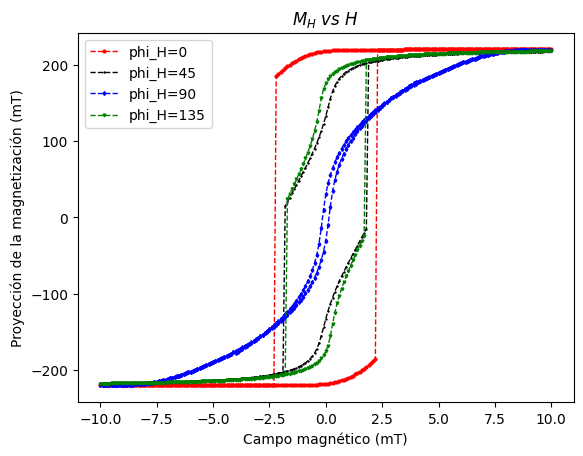

In [2]:
H_dict = dict()
M_dict = dict()

# Ángulos phi_H en grados para los que se realizarán los cálculos
for phi_H_grados in [0, 45, 90, 135]:  
    parametros = {
    "M": 220,     # mT
    "Hc": 3.2,
    "Hu": 4.1,
    "H": 10,     # mT
    "phi_u": -2,
    "phi_H": phi_H_grados
}
    # Cálculo de phi_M y H
    phi_M, H = angulo(parametros,paso=1e-2)
    M = []

    # Hallamos la proyección de la magnetización a lo largo del campo magnético M_H = M · H
    phi_H_rad = np.radians(parametros["phi_H"])
    H_u = np.array([np.cos(phi_H_rad), np.sin(phi_H_rad), 0])
    
    for a in phi_M:
        M_temp = parametros["M"] * np.array([np.cos(a), np.sin(a), 0])
        M_proyectH = np.dot(M_temp, H_u)
        M.append(M_proyectH)
    
    M = np.array(M, float)
    H_dict[phi_H_grados] = H
    M_dict[phi_H_grados] = M
for phi_H,color,s in zip([0,45,90,135],["red","black","blue","green"],["o","+","d","v","^"]):    # Parámetros
    plt.plot(H_dict[phi_H],M_dict[phi_H],label=f"phi_H={phi_H}",color=color,marker=s,ms=2,ls="--",lw=1)
plt.legend()
plt.xlabel("Campo magnético (mT)")
plt.ylabel("Proyección de la magnetización (mT)")
plt.title(r"$M_H~vs~H$")
#plt.xlim((-1,1))
plt.savefig("kerrefect.png",dpi=300)
plt.show()



# Simulación de magnetorresistencia anisotrópica

Para conocer las densidades de corriente, usando la ley de Ohm generalizada, y suponiendo que la corriente y el la manetización están en el plano donde se encuentra la película, es decir:
$$\textbf{M}=M\left[\begin{matrix}
cos(\phi_M)\\
sen(\phi_M)\\
0
\end{matrix}
\right] $$
$$\textbf{J}=J\left[\begin{matrix}
cos(\phi_J)\\
sen(\phi_J)\\
0
\end{matrix}
\right] $$
Podemos obtener las componentes del campo eléctrico externo al que sometemos a la película.<br>
Como primera aproximación vamos a ignorar los efectos de Hall anómalo, magnetoresistencia oridinaria y efecto hall ordinario. Entonces las componentes del campo son:
$$E_{xx}=J\rho_{\perp}\cos\phi_J+\Delta\rho \cos\phi_M\cdot (cos\phi_J\cos\phi_M+\sin\phi_J\sin\phi_M) $$
$$E_{xy}=J\rho_{\perp}\sin\phi_J+\Delta\rho \sin\phi_M\cdot (cos\phi_J\cos\phi_M+\sin\phi_J\sin\phi_M) $$
Suponiendo que medimos los ángulos con la dirección de la corriente como referenica, es decir $\phi_J=0$ y sea $\psi=\phi_M-\phi_J=\phi_M$, entonces se tienen las expresiones:
$$E_x=J(\rho_{\perp}+\Delta\rho \cos^2\psi)$$
$$E_y=J\Delta \rho\cos\psi \sin\psi $$
Las diferencia de potencial asociadas a esto campos son, por tanto:
$$ V_{xx}=Jt(\rho_{\perp}+\Delta\rho \cos^2\psi)$$
$$V_{xy}=Jt\Delta \rho\cos\psi \sin\psi  $$
donde t es el grosor de la película.
Resolviendo el sistema de ecuaciones, tenemos las expresiones para $\Delta \rho$ y $\rho_{\perp}$:
$$\Delta\rho=\frac{V_{xy}}{Jt}\frac{1}{sen\psi\cos\psi}$$
$$\rho_{\perp}=\frac{1}{Jt}\left(V_{xx}-V_{xy}\cot\psi\right) $$
La expresión para la AMR es:
$$AMR=\frac{\Delta\rho}{\rho_{\perp}}=\frac{1}{\sin\psi\cos\psi}\frac{V_{xy}}{V_{xx}-V_{xy}\cot\psi} $$
De las expresiones para las diferencias de potencial podemos obtener los valores de la resistencia :
$$R_{xx} = R_{\perp}+\Delta R \cos^2\psi $$
$$R_{xy} = \Delta R \cos\psi \sin \psi $$
donde $\Delta R=R_{\perp}-R_{\|}$

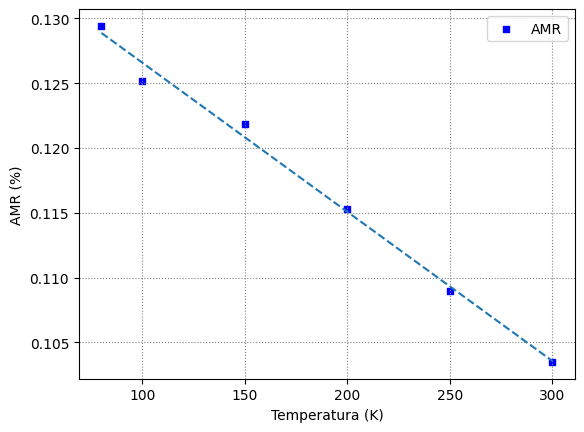

In [3]:
#Determinemos experimentalmente las resistencias  R_T R_P

# Definiciones iniciales
base_dir = "Datos/RvsH_angle_vsT_SECTOR1/"
temp = [80, 100,150, 200, 250,300]
sufijo = "K_300mT_angular.txt"
dfs = dict()
# Creamos un diccionario con los datos experimentales para cada temperatura
for t in temp:
    path=base_dir+str(t)+sufijo
    dfs[t]=leer_archivo(path)

# Definición de funciones de ajuste
def rxx_func(psi, r_p, dr):
    return r_p + dr * np.cos(psi)**2
"""Este porsiaca"""
def rxy_func(psi, dr):
    return dr * np.sin(psi)*np.cos(psi)

# diccionarios
r_ps,drs=dict(),dict()
a_s,drs2=dict(),dict()

amrs=dict()
cos2=dict()
for t in temp:
    # Elegimos el Dataframe para la temperatura t
    df=dfs[t]
    # Valores experimentales
    Rxx = df["Rxx (ohm)"].to_numpy()
    
    Rxy = df["Rxy (ohm)"].to_numpy()
    
    psi = df["angle (°)"].to_numpy()
    psi=np.radians(psi)
    # Ajuste usando scipy.optimize
    fit_values,cov=curve_fit(rxx_func,psi,Rxx)    
    r_p,dr=fit_values

    fit_values,cov=curve_fit(rxy_func,psi,Rxx)    
    dr2=fit_values

    # Cálculo de valores de AMR
    amr = dr/r_p*100
    # Guardar valores en diccionarios
    cos2[t]=(Rxx-r_p)/dr
    r_ps[t]=r_p
    drs[t]=dr
    drs2[t]=dr2
    amrs[t]=amr
p = np.poly1d(np.polyfit(temp, list(amrs.values()), 1))
plt.scatter(temp,amrs.values(),label="AMR",s=20,color="blue",marker="s")
plt.plot(temp,p(temp),"--")
plt.legend()
plt.xlabel("Temperatura (K)")
plt.ylabel("AMR (%)")
plt.grid(color="grey",linestyle=":" )
plt.show()    

# Determinación de los parámetros $H_u$ y $H_c$

Una manera de poder determimar los campos magnetocristalino y uniaxial, $H_u \text{ y } H_c$, respectivamente; es tratar de ajustar la curva obtenida de $\cos\psi\sin\psi$ obtenida experimentalmente y la calculada .

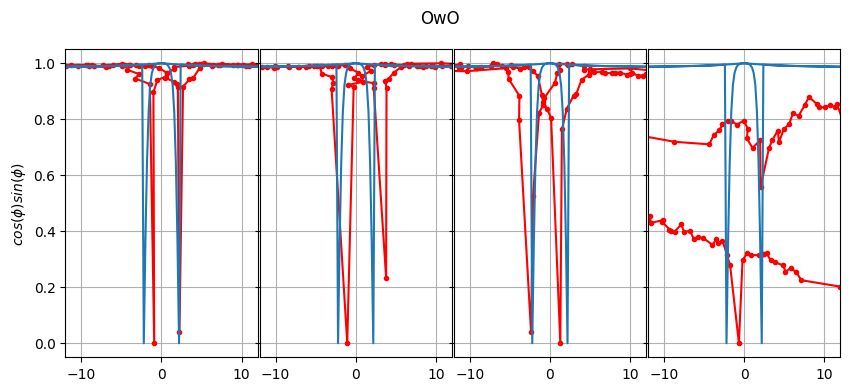

In [4]:

def iter(a,b,phi_H_grados=3,title=""):
    parametros = {
            "M": 17,     # mT
            "Hc": a,
            "Hu": b,
            "H": 20,     # mT
            "phi_u": 0,
            "phi_H": phi_H_grados
        }

    # Cálculo de phi_M y H
    phi_M, H = angulo(parametros,paso=1e-2)
    # Definiciones iniciales 
    base_dir = "Datos/RvsHvsT_SECTOR2/EA/"
    temp = [80,100,200,300]
    sufijo = "K.txt"
    dfs2 = dict()
    # Creamos un diccionario con los datos experimentales para cada temperatura
    for t in temp:
        path=base_dir+str(t)+sufijo
        dfs2[t]=leer_archivo(path)
    fig,ax=plt.subplots(1,len(temp),figsize=(10, 4))
    k=0
    for t in temp:
        df=dfs2[t]
        rxy=df["Rxy (ohm)"].to_numpy()
        rxx=df["Rxx (ohm)"].to_numpy()
        h=df['Magnetic Field (T)'].to_numpy()*1000
        cossin=(rxy)
        cos2 = (rxx-min(rxx))/abs(max(rxx)-min(rxx))
        teo = np.cos(phi_M)*np.cos(phi_M)
        teo2 = (teo-min(teo))/abs(max(teo)-min(teo))
        ax[k].plot(h-1.3,cos2,"-r.")
        ax[k].plot(H,teo2)
        
        ax[k].plot()
        ax[k].grid()
        #ax[k].tick_params(labelbottom=False)    
        ax[k].set_xlim((-12,12))
        ax[k].tick_params(labelleft=False)    

        k+=1
    ax[0].tick_params(labelleft=True)    
    fig.subplots_adjust(wspace=0.01)
    ax[0].set_ylabel(r"$cos(ϕ)sin(ϕ)$")
    #fig.set_xlabel("Campo Magnético (mT)")
    fig.suptitle(title)
    plt.show()

#print5,9(i,j)
iter(2.1,4.1,title="OwO")

        

In [5]:

def mostrar_sector3(parametros,shift_field=0,shift_angle=0,title=""):
    base_dir="Datos/RvsHvsH_angle_SECTOR3/80K/80_"
    # Cálculo de phi_M y H
    # Definiciones iniciales 
    angulos = [0,15,30,45,60,90,120,180]
    sufijo = ".txt"
    dfs2 = dict()
    # Creamos un diccionario con los datos experimentales para cada temperatura
    for a in angulos:
        path=base_dir+str(a)+sufijo
        dfs2[a]=leer_archivo(path)
    fig,ax=plt.subplots(2,int(len(angulos)/2),figsize=(10, 6))
    k=0
    l=0
    for a in angulos:
        # Datos experimentales
        df=dfs2[a]
        rxy=df["Rxy (ohm)"].to_numpy()
        rxx=df["Rxx (ohm)"].to_numpy()
        h=df['Magnetic Field (T)'].to_numpy()*1000

        # Simulación teórica
        parametros["phi_H"]=a+shift_angle       
        phi_M,H=angulo(parametros,paso=1e-2)
        rxx_normalizado = (rxx-min(rxx))/abs(max(rxx)-min(rxx))
        teo = np.cos(phi_M)*np.cos(phi_M)
        teo2 = (teo-min(teo))/abs(max(teo)-min(teo))
        ax[k][l].plot(h+shift_field,rxx_normalizado,"-r.",label="experimental")
        ax[k][l].plot(H,teo2,label="teorico,"+r"$\phi_H$"+f"={a}")
        
        ax[k][l].plot()
        ax[k][l].grid()
        #ax[k].tick_params(labelbottom=False)    
        ax[k][l].set_xlim((-50-5,50+5))
        ax[k][l].tick_params(labelleft=True)    
        ax[k][l].set_xlabel("Campo magnético (mT)")
        ax[k][l].legend()
        l+=1
        if l==round(len(angulos)/2):
            l=0
            k+=1
        #ax[0][:].tick_params(labelleft=True)    
    fig.subplots_adjust(wspace=0.01)
    ax[0][0].set_ylabel(r"$cos(ϕ)^2$")
    ax[1][0].set_ylabel(r"$cos(ϕ)^2$")
        #fig.set_xlabel("Campo Magnético (mT)")
    plt.suptitle(title)
    plt.savefig(f"amr{parametros['Hc'],parametros['Hu']}.png")
    
    plt.show()

        

In [6]:

def mostrar_sector3_2(parametros,shift_field=0,shift_angle=0,title=""):
    base_dir="Datos/RvsHvsH_angle_SECTOR3/80K/80_"
    # Cálculo de phi_M y H
    # Definiciones iniciales 
    angulos = [0,15,30,45,60,90,120,180]
    sufijo = ".txt"
    dfs2 = dict()
    # Creamos un diccionario con los datos experimentales para cada temperatura
    for a in angulos:
        path=base_dir+str(a)+sufijo
        dfs2[a]=leer_archivo(path)
    fig,ax=plt.subplots(2,int(len(angulos)/2),figsize=(10, 6))
    k=0
    l=0
    for a in angulos:
        # Datos experimentales
        df=dfs2[a]
        rxy=df["Rxy (ohm)"].to_numpy()
        rxx=df["Rxx (ohm)"].to_numpy()
        h=df['Magnetic Field (T)'].to_numpy()*1000

        # Simulación teórica
        parametros["phi_H"]=a+shift_angle       
        phi_M,H=angulo(parametros,paso=1e-2)
        rxy_normalizado = (rxy-min(rxy))/abs(max(rxy)-min(rxy))
        teo = 0.5*np.cos(phi_M)*np.sin(phi_M)
        teo2 = (teo-min(teo))/abs(max(teo)-min(teo))
        ax[k][l].plot(h+shift_field,rxy_normalizado,"-r.",label="experimental")
        ax[k][l].plot(H,teo2,label="teorico,"+r"$\phi_H$"+f"={a}")
        
        ax[k][l].plot()
        ax[k][l].grid()
        #ax[k].tick_params(labelbottom=False)    
        ax[k][l].set_xlim((-50-5,50+5))
        ax[k][l].tick_params(labelleft=True)    
        ax[k][l].set_xlabel("Campo magnético (mT)")
        ax[k][l].legend()
        l+=1
        if l==round(len(angulos)/2):
            l=0
            k+=1
        #ax[0][:].tick_params(labelleft=True)    
    fig.subplots_adjust(wspace=0.01)
    ax[0][0].set_ylabel(r"$cos(ϕ)sin(ϕ)$")
    ax[1][0].set_ylabel(r"$cos(ϕ)sin(ϕ)$")
    #fig.set_xlabel("Campo Magnético (mT)")
    plt.suptitle(title)
    plt.savefig(f"amr{parametros['Hc'],parametros['Hu']}.png")
    plt.show()

        

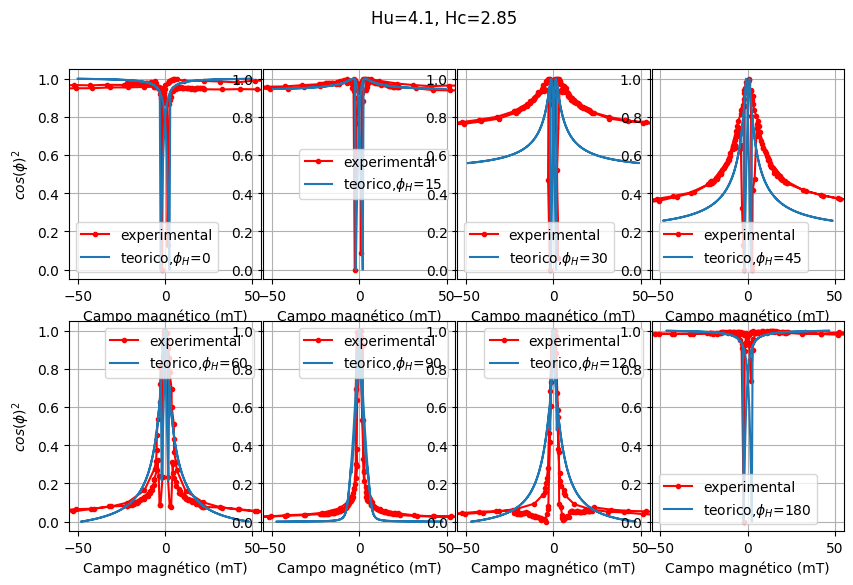

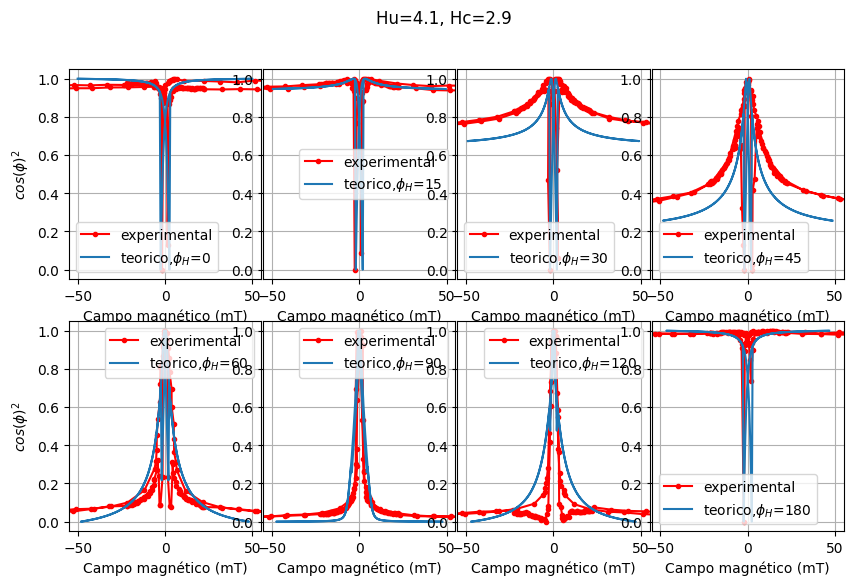

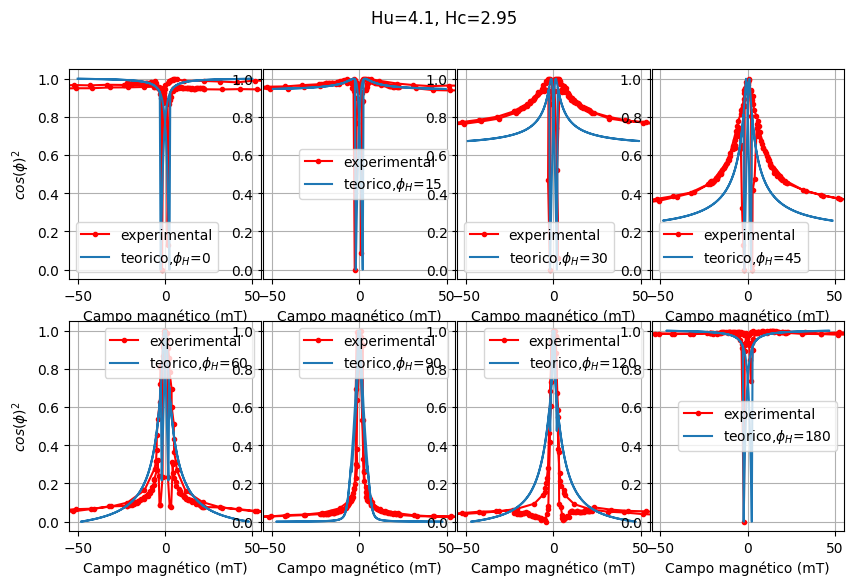

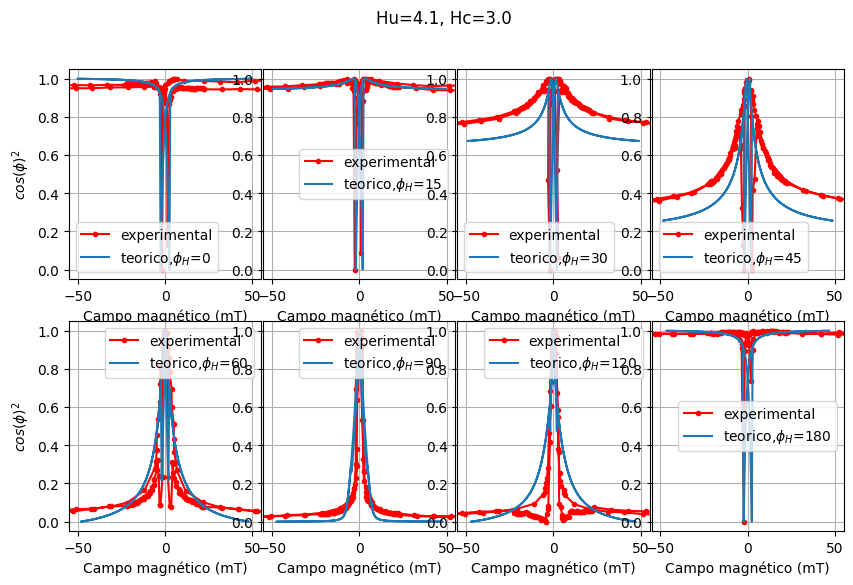

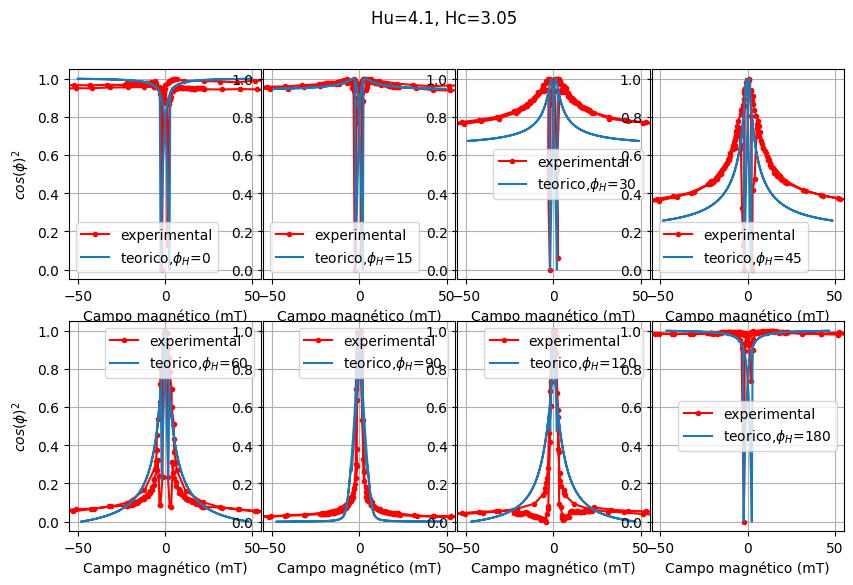

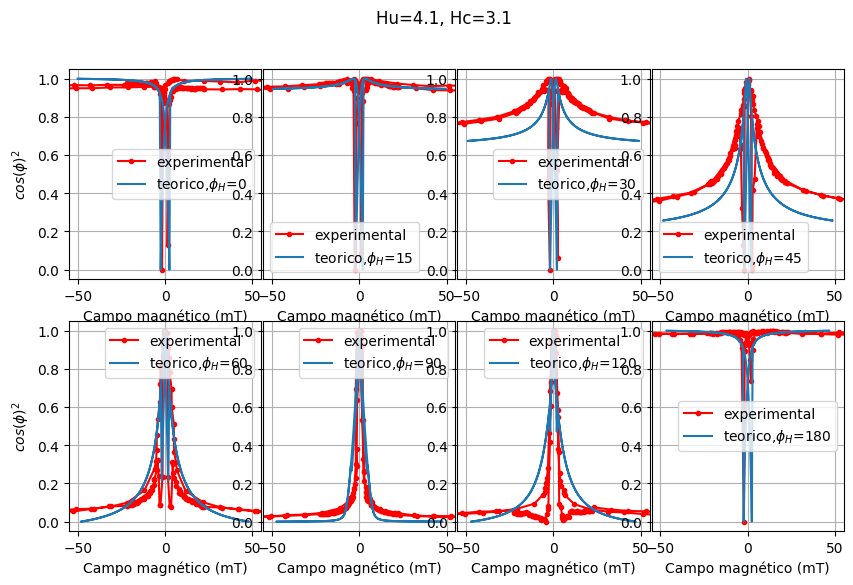

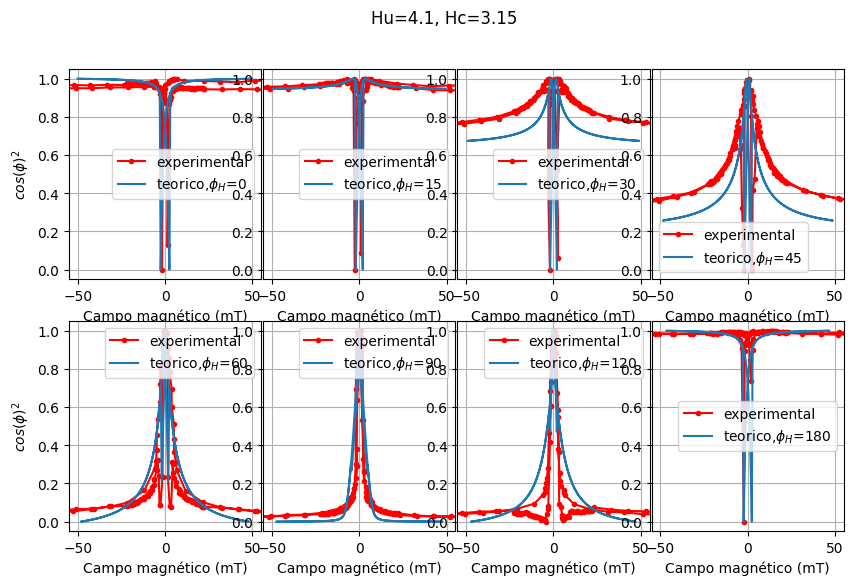

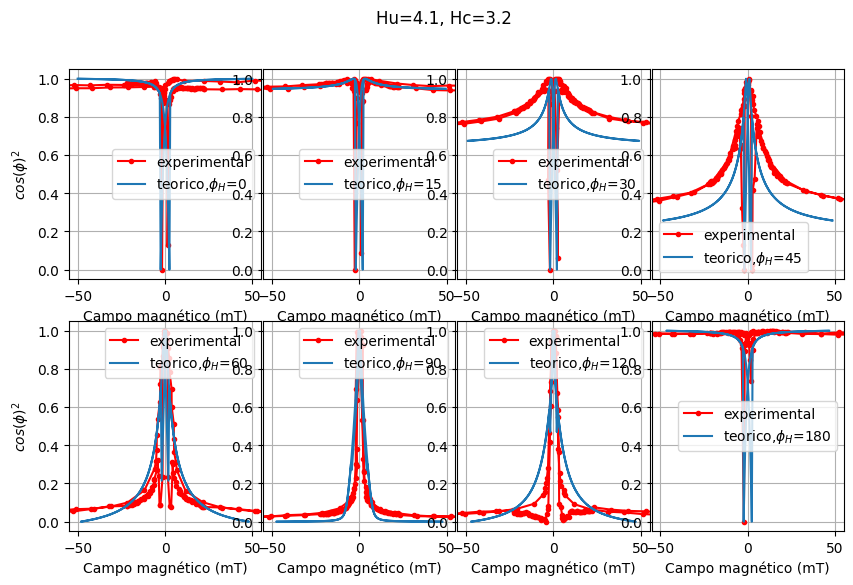

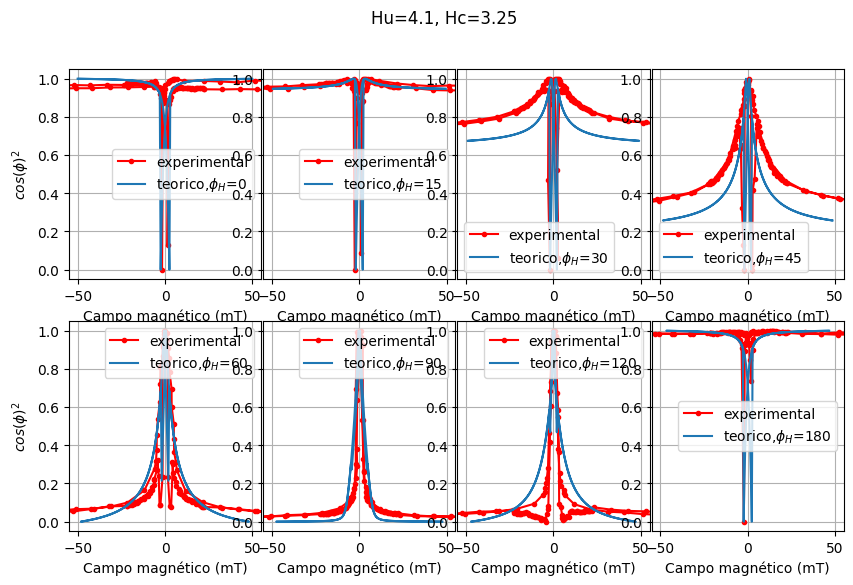

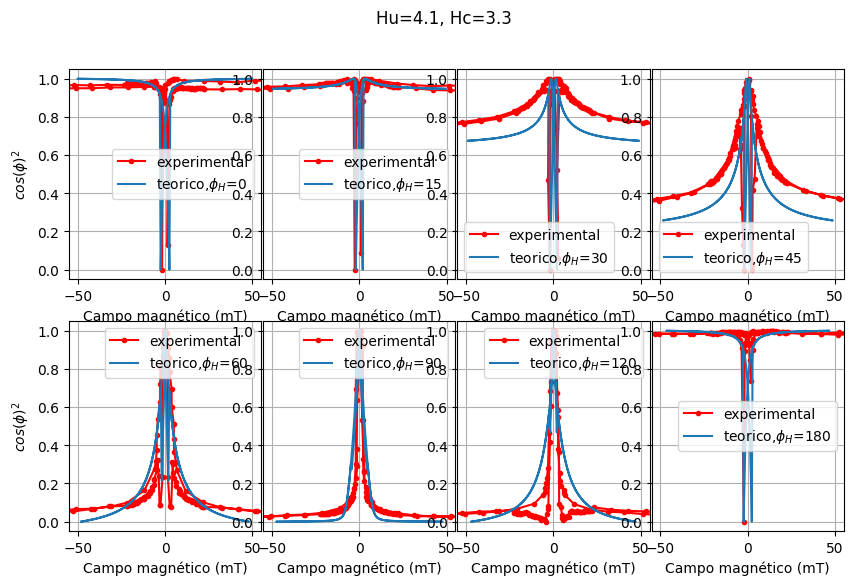

In [7]:
Hc=3.1
Hu=4.1
parametros = {
    "M": 170,     # mT
    "Hc": Hc,
    "Hu": Hu,
    "H": 50,     # mT
    "phi_u": -7.1,
}
for n in range(-5,5):
    Hc=3.1+0.05*n
    Hu=4.1
    parametros = {
        "M": 170,     # mT
        "Hc": round(Hc,2),
        "Hu": round(Hu,2),
        "H": 50,     # mT
        "phi_u": -7.1,
    }
    mostrar_sector3(parametros,shift_angle=-6.1,shift_field=-1,title=f"Hu={parametros['Hu']}, Hc={parametros['Hc']}")


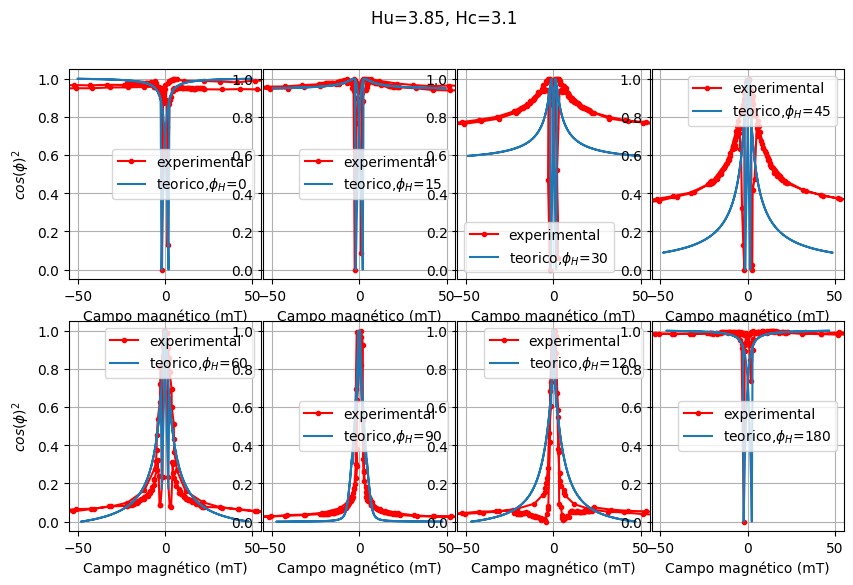

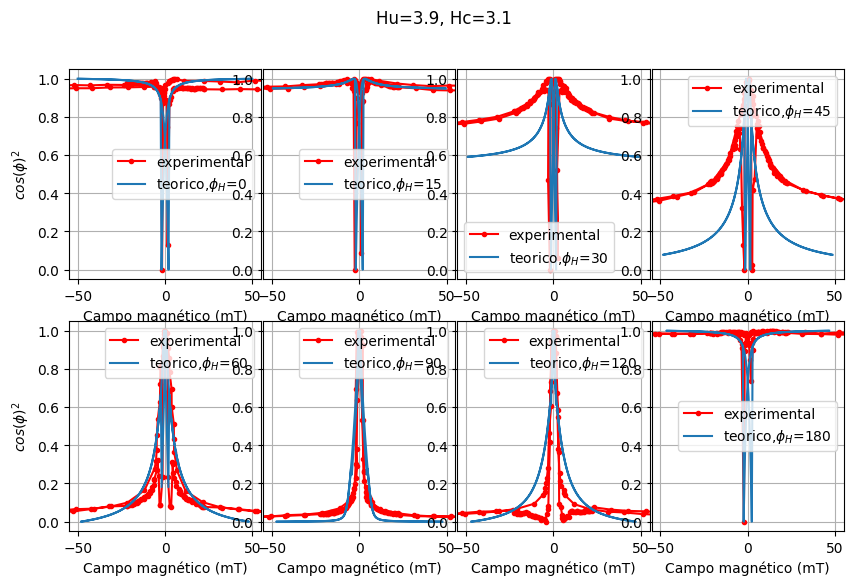

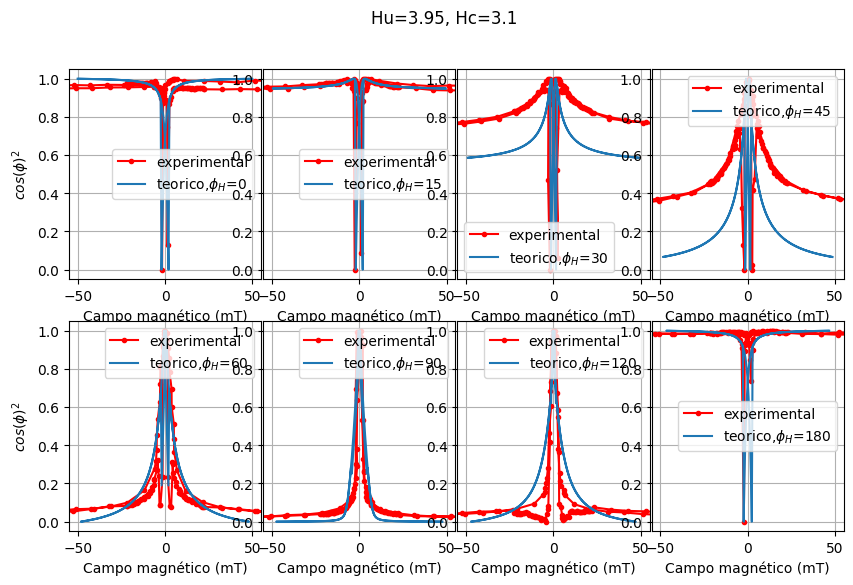

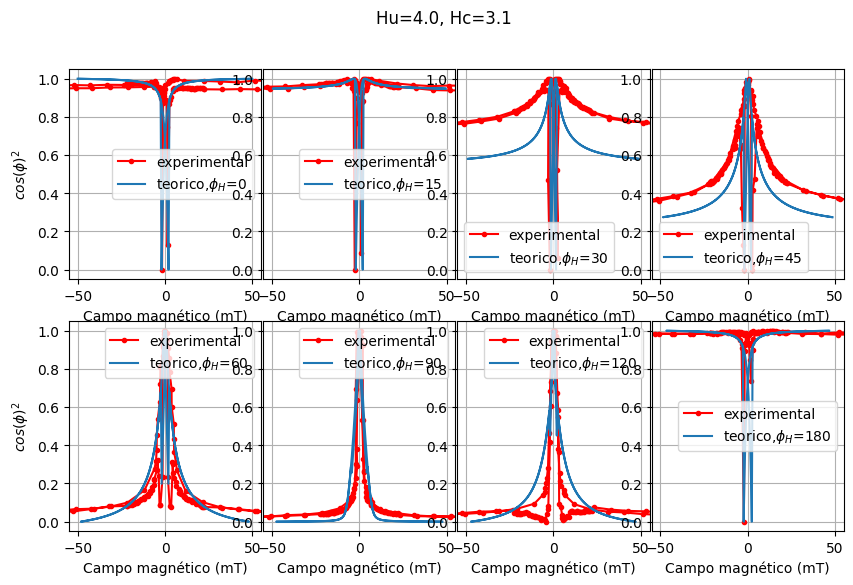

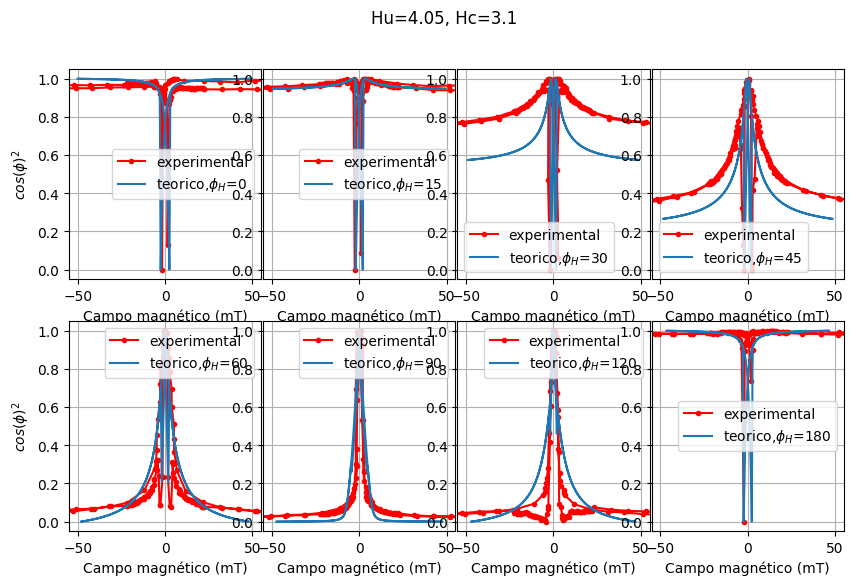

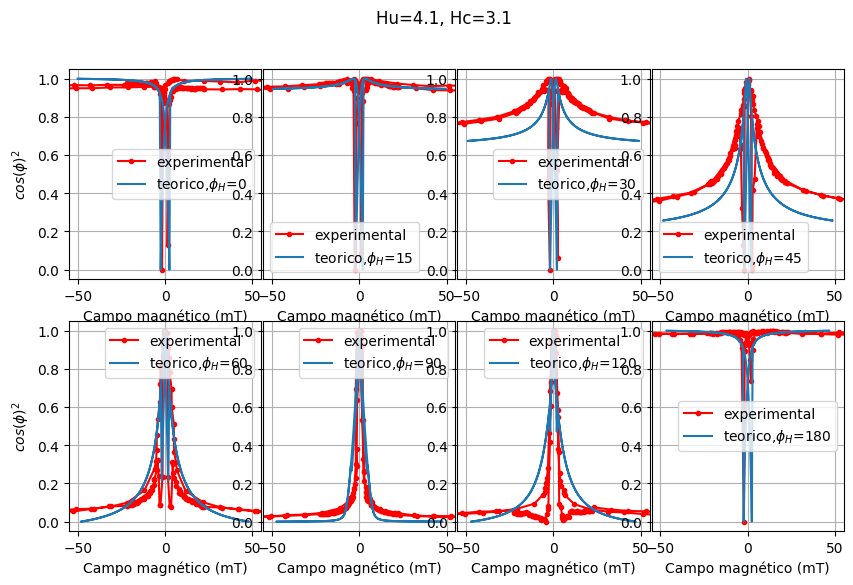

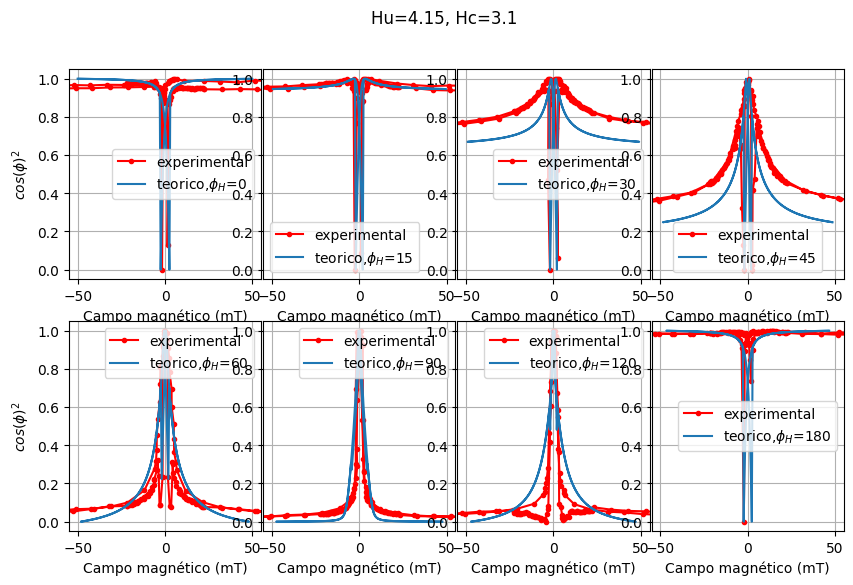

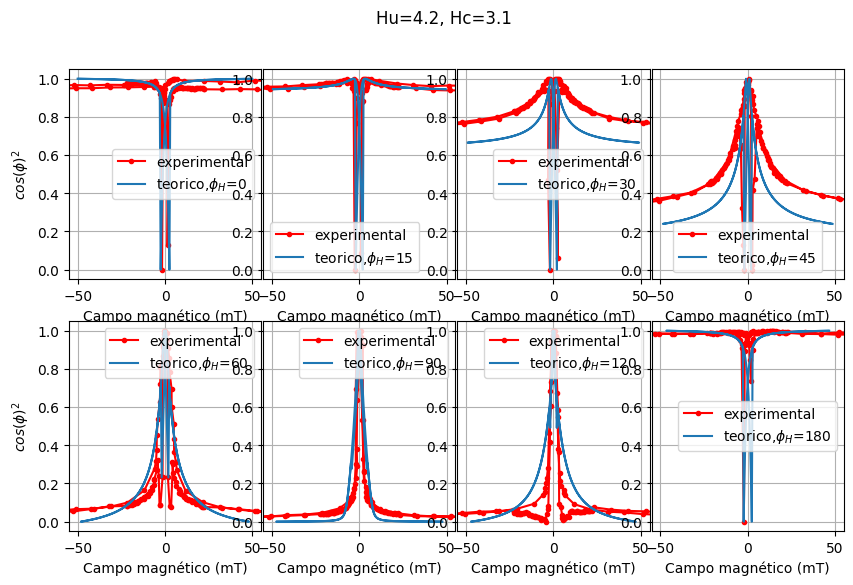

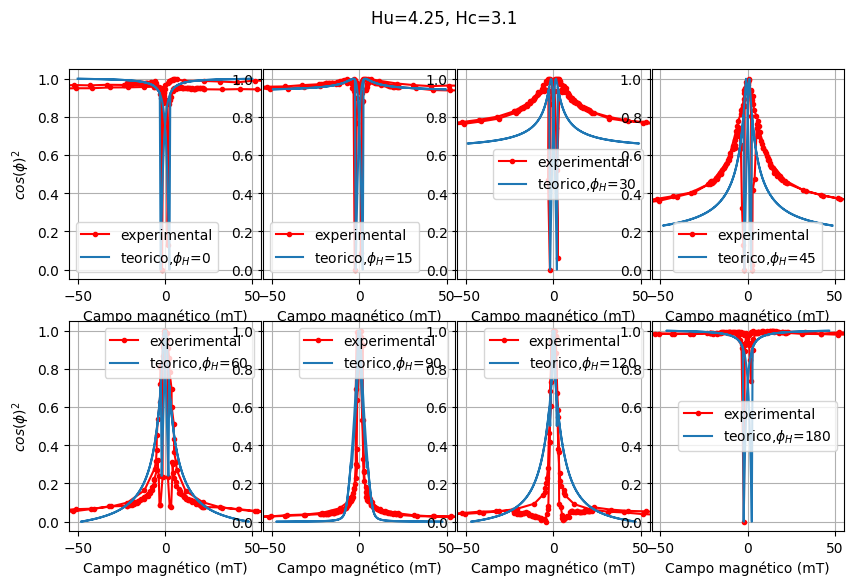

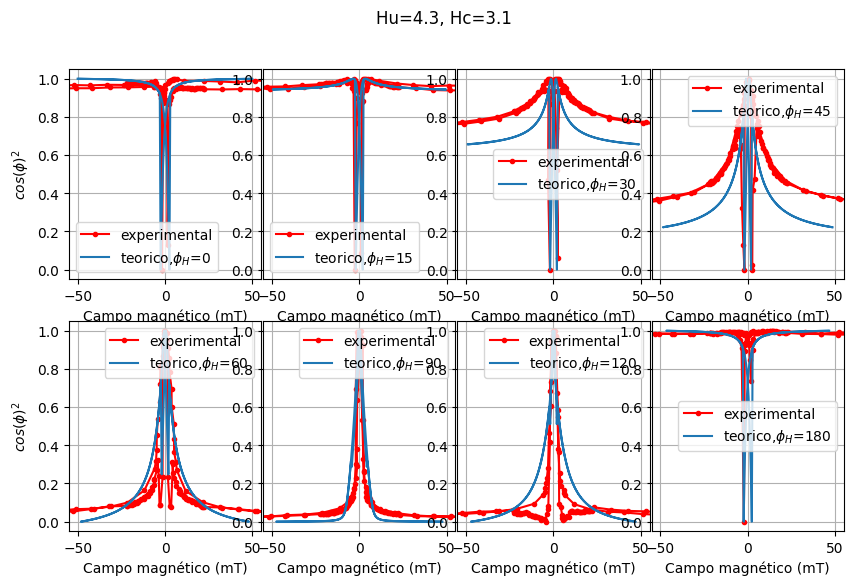

In [8]:
for n in range(-5,5):
    Hc=3.1
    Hu=4.1+0.05*n
    parametros = {
        "M": 170,     # mT
        "Hc": round(Hc,2),
        "Hu": round(Hu,2),
        "H": 50,     # mT
        "phi_u": -7.1,
    }
    mostrar_sector3(parametros,shift_angle=-6.1,shift_field=-1,title=f"Hu={parametros['Hu']}, Hc={parametros['Hc']}")


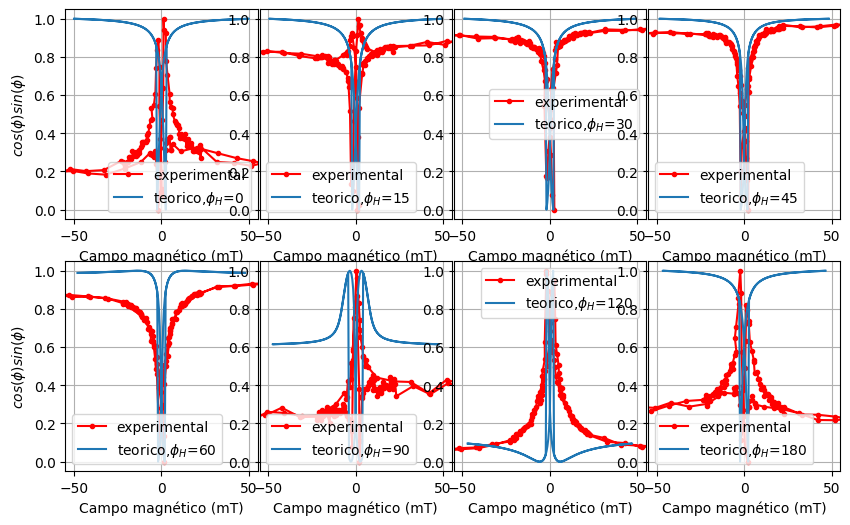

In [9]:
parametros = {
    "M": 170,     # mT
    "Hc":   Hc,
    "Hu": Hu,
    "H": 50,     # mT
    "phi_u": -5.1,
    "phi_H": 0
}
mostrar_sector3_2(parametros,shift_angle=-6.1,shift_field=-1)

In [10]:
def fiting(boolean_value):
    if boolean_value==True: 
        # Definiciones iniciales 
        base_dir = "Datos/RvsHvsH_angle_SECTOR3/80K/80_"
        temp = [80]
        angulos = [-15.0,0,15,30,45,60,90,135,180]
        sufijo = ".txt"
        dfs_80 = dict()
        # Creamos un diccionario con los datos experimentales para cada temperatura
        H_c_list,H_u_list=list(),list()
        for a in angulos:
            path = base_dir+str(a)+sufijo
            dfs_80[a] = leer_archivo(path)

        parametros = {
            "M": 170,     # mT
            "Hc": 3.1,
            "Hu": 4.1,
            "H": 50,     # mT
            "phi_u": -7,
            "phi_H": 0
        }


        for a in angulos:
            df = dfs_80[a]
            rxy = df["Rxy (ohm)"]
            h = df["Magnetic Field (T)"]*1000-1
            phi_H=np.radians(a+1)
            rxy_normalizado=(rxy-min(rxy))/abs((max(rxy)-min(rxy)))
            experimental=np.array(rxy_normalizado,float)


            def error(valores):
                Hu,Hc=valores
                parametros["Hu"]=Hu
                parametros["Hc"]=Hc
                parametros["phi_H"]=a-8.1
                phi_M=list()
                for H in h:  
                    parametros["H"]=H  
                    angulo= angulo2(parametros)
                    phi_M.append(angulo)
                phi_M=np.array(phi_M,float)
                sincos=np.sin(phi_M)*np.cos(phi_M)
                teorico=(sincos-min(sincos))/abs((max(sincos)-min(sincos)))
                error=abs(experimental-teorico)
                return np.sum(error)
                #return np.sum((rxy_normalizado-np.sin(phi_M)*np.cos(phi_M))**2)


            resultado = minimize(error, [3.1, 4.1],)
            Hc_opt, Hu_opt = resultado.x[0], resultado.x[1]
            print(Hc_opt, Hu_opt)
            parametros["Hu"]=Hu_opt
            parametros["Hc"]=Hc_opt
            mostrar_sector3(parametros)
        else:
            print("")
fiting(False)